In [1]:
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import datasets,transforms

In [2]:
train=datasets.MNIST(
    '../data',train=True,download=True,
    transform=transforms.Compose([
        transforms.ToTensor()
    ]),
)

test=datasets.MNIST(
    '../data',train=False,
    transform=transforms.Compose([
        transforms.ToTensor()
    ]),
)

In [3]:
def plot(x):
    img=(np.array(x.detach().cpu(),dtype='float')).reshape(28,28)
    plt.imshow(img,cmap='gray')
    plt.show()

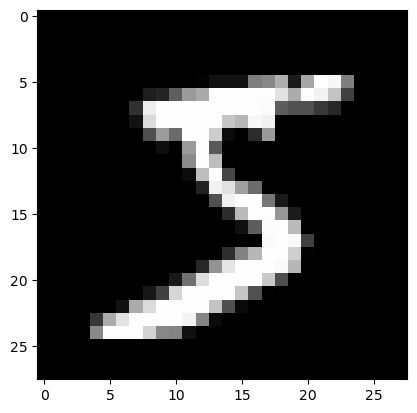

In [5]:
plot(train.data[0])

In [6]:
x=train.data.float()/255.
y=train.targets
x=x.view(x.size(0),-1)
print(x.shape,y.shape)

torch.Size([60000, 784]) torch.Size([60000])


In [7]:
input_size=x.size(-1)
output_size=int(max(y))+1
print('input_size: %d, output_size: %d' % (input_size,output_size))

input_size: 784, output_size: 10


In [8]:
# Train / Valid ratio
ratios=[.8,.2]

train_cnt=int(x.size(0)*ratios[0])
valid_cnt=int(x.size(0)*ratios[1])
test_cnt=len(test.data)
cnts=[train_cnt,valid_cnt]

print("Train %d / Valid %d / Test %d samples." % (train_cnt,valid_cnt,test_cnt))

indices=torch.randperm(x.size(0))

x=torch.index_select(x,dim=0,index=indices)
y=torch.index_select(y,dim=0,index=indices)

x=list(x.split(cnts,dim=0))
y=list(y.split(cnts,dim=0))

x+=[(test.data.float()/255.).view(test_cnt,-1)]
y+=[test.targets]

for x_i,y_i in zip(x,y):
    print(x_i.size(),y_i.size())

Train 48000 / Valid 12000 / Test 10000 samples.
torch.Size([48000, 784]) torch.Size([48000])
torch.Size([12000, 784]) torch.Size([12000])
torch.Size([10000, 784]) torch.Size([10000])


In [9]:
model=nn.Sequential(
    nn.Linear(input_size,500),
    nn.LeakyReLU(),
    nn.Linear(500,400),
    nn.LeakyReLU(),
    nn.Linear(400,300),
    nn.LeakyReLU(),
    nn.Linear(300,200),
    nn.LeakyReLU(),
    nn.Linear(200,100),
    nn.LeakyReLU(),
    nn.Linear(100,50),
    nn.LeakyReLU(),
    nn.Linear(50,output_size),
    nn.LogSoftmax(dim=-1),
)

In [10]:
optimizer=optim.Adam(model.parameters())
crit=nn.NLLLoss()

In [11]:
device=torch.device('cpu')
if torch.cuda.is_available():
    device=torch.device('cuda')

In [12]:
model=model.to(device)
x=[x_i.to(device) for x_i in x]
y=[y_i.to(device) for y_i in y]

In [13]:
n_epochs=1000
batch_size=256
print_interval=10
early_stop=50
lowest_loss=np.inf
best_model=None
lowest_epoch=np.inf

In [14]:
train_history,valid_history=[],[]

for i in range(n_epochs):
    indices=torch.randperm(x[0].size(0)).to(device)
    x_=torch.index_select(x[0],dim=0,index=indices)
    y_=torch.index_select(y[0],dim=0,index=indices)
    
    x_=x_.split(batch_size,dim=0)
    y_=y_.split(batch_size,dim=0)
    
    train_loss,valid_loss=0,0
    y_hat=[]
    
    for x_i,y_i in zip(x_,y_):
        y_hat_i=model(x_i)
        loss=crit(y_hat_i,y_i.squeeze())
        
        optimizer.zero_grad()
        loss.backward()
        
        optimizer.step()
        train_loss+=float(loss)
    
    train_loss=train_loss/len(x_)
    
    with torch.no_grad():
        x_=x[1].split(batch_size,dim=0)
        y_=y[1].split(batch_size,dim=0)
        
        valid_loss=0
        
        for x_i,y_i in zip(x_,y_):
            y_hat_i=model(x_i)
            loss=crit(y_hat_i,y_i.squeeze())
            
            valid_loss=float(loss)
            
            y_hat+=[y_hat_i]
    
    valid_loss=valid_loss/len(x_)
    
    train_history+=[train_loss]
    valid_history+=[valid_loss]
    
    if (i + 1) % print_interval == 0:
        print('Epoch %d: train loss=%.4f valid_loss=%.4f lowest_loss=%.4f' %
(
            i+1,
            train_loss,
            valid_loss,
            lowest_loss,
        ))
    
    if valid_loss<=lowest_loss:
        lowest_loss=valid_loss
        lowest_epoch=i
        
        best_model=deepcopy(model.state_dict())
    else:
        if early_stop > 0 and lowest_epoch + early_stop < i + 1:
            print("There is no improvement during last %d epochs." % early_stop)
            break

print("The best validation loss from epoch %d: %.4f" %(lowest_epoch+1,lowest_loss))
model.load_state_dict(best_model)

Epoch 10: train loss=0.0249 valid_loss=0.0031 lowest_loss=0.0024
Epoch 20: train loss=0.0125 valid_loss=0.0025 lowest_loss=0.0024
Epoch 30: train loss=0.0086 valid_loss=0.0031 lowest_loss=0.0021
Epoch 40: train loss=0.0054 valid_loss=0.0021 lowest_loss=0.0021
Epoch 50: train loss=0.0082 valid_loss=0.0027 lowest_loss=0.0021
Epoch 60: train loss=0.0110 valid_loss=0.0025 lowest_loss=0.0021
Epoch 70: train loss=0.0000 valid_loss=0.0038 lowest_loss=0.0019
Epoch 80: train loss=0.0000 valid_loss=0.0043 lowest_loss=0.0019
Epoch 90: train loss=0.0000 valid_loss=0.0047 lowest_loss=0.0019
Epoch 100: train loss=0.0000 valid_loss=0.0051 lowest_loss=0.0019
Epoch 110: train loss=0.0000 valid_loss=0.0055 lowest_loss=0.0019
There is no improvement during last 50 epochs.
The best validation loss from epoch 62: 0.0019


<All keys matched successfully>

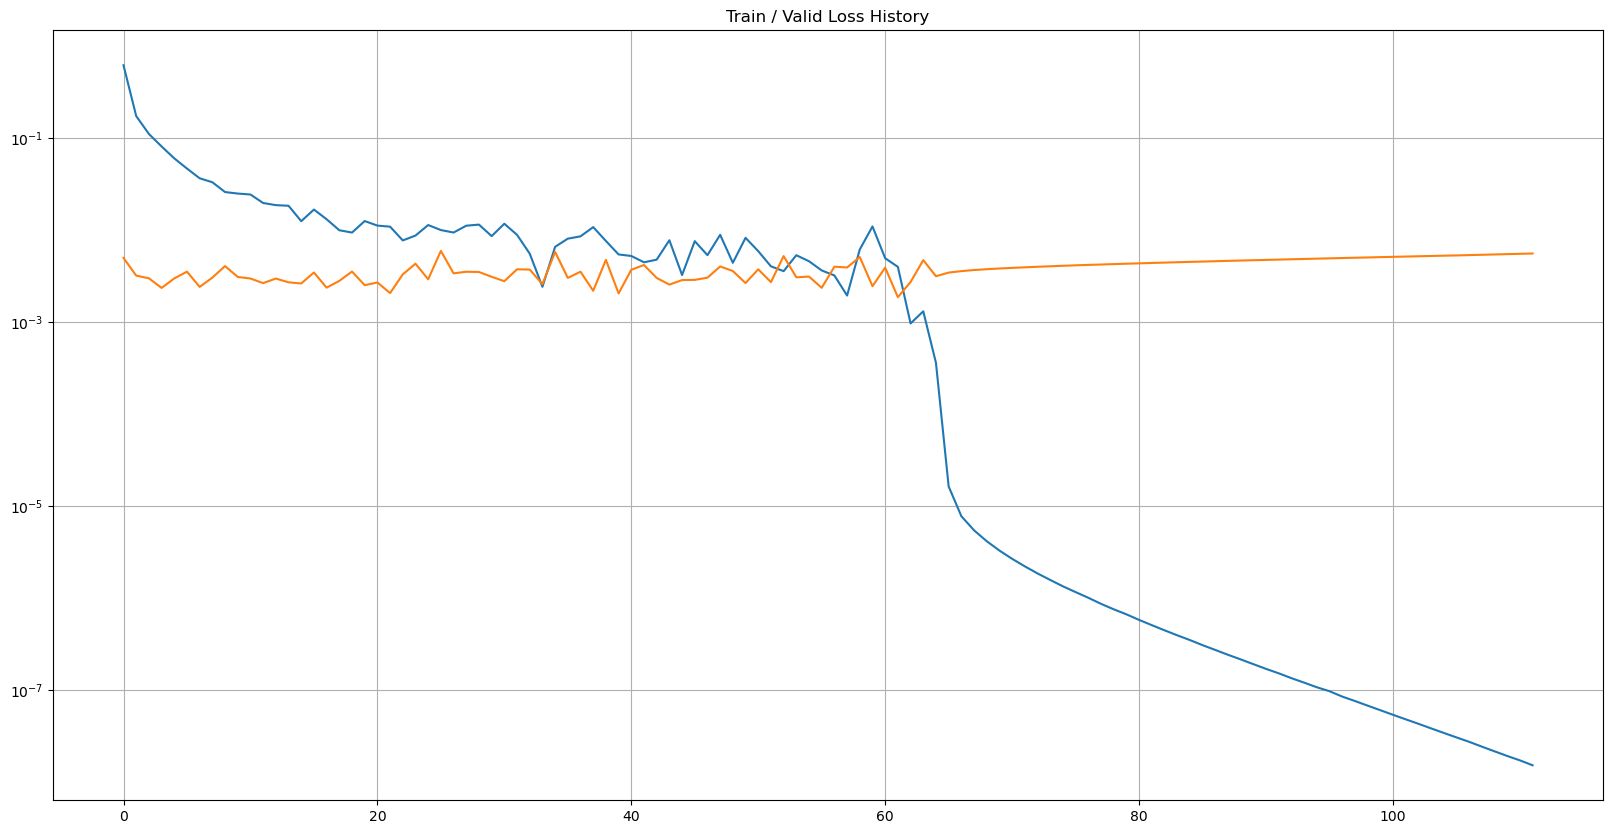

In [15]:
plot_from=0

plt.figure(figsize=(20,10))
plt.grid(True)
plt.title("Train / Valid Loss History")
plt.plot(
    range(plot_from,len(train_history)),train_history[plot_from:],
    range(plot_from,len(valid_history)),valid_history[plot_from:],
)
plt.yscale('log')
plt.show()

In [16]:
test_loss=0
y_hat=[]

with torch.no_grad():
    x_=x[-1].split(batch_size,dim=0)
    y_=y[-1].split(batch_size,dim=0)
    
    for x_i,y_i in zip(x_,y_):
        y_hat_i=model(x_i)
        loss=crit(y_hat_i,y_i.squeeze())
        test_loss+=loss
        
        y_hat+=[y_hat_i]
    
test_loss=test_loss/len(x_)
y_hat=torch.cat(y_hat,dim=0)

print("Test loss: %.4e" % test_loss)

Test loss: 1.1567e-01


In [20]:
correct_cnt=(y[-1].squeeze()==torch.argmax(y_hat,dim=-1)).sum()
total_cnt=float(y[-1].size(0))
print("Test Accuracy: %.4f" %(correct_cnt/total_cnt))

Test Accuracy: 0.9821


In [21]:
import pandas as pd
from sklearn.metrics import confusion_matrix

In [25]:
# Cuda:0 유형 텐서를 numpy로 변환할 때는
# 텐서 뒤에 .cpu()를 붙여야 한다.
pd.DataFrame(confusion_matrix(y[-1].cpu(),torch.argmax(y_hat.cpu(),dim=-1)),
               index=['true_%d' % i for i in range(10)],
               columns=['pred_%d' % i for i in range(10)])

,pred_0,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6,pred_7,pred_8,pred_9
true_0,968,0,0,1,1,1,4,0,3,2
true_1,0,1126,0,2,0,1,2,1,3,0
true_2,6,1,1006,7,2,0,1,4,5,0
true_3,0,0,1,996,0,7,0,2,2,2
true_4,1,1,3,0,963,0,7,1,0,6
true_5,2,0,0,6,0,874,5,0,4,1
true_6,1,3,1,1,2,3,945,0,2,0
true_7,0,4,6,2,1,1,0,1006,1,7
true_8,2,0,2,5,1,7,1,2,950,4
true_9,1,4,0,0,10,3,1,1,2,987
